<a href="https://colab.research.google.com/github/Pramurta/Neural-Nets-Assignment-2/blob/main/Inception_with_pre_processing_MINC_2500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras

Downloading and extracting the MINC-2500 dataset

In [ ]:
!wget -cq http://opensurfaces.cs.cornell.edu/static/minc/minc-2500.tar.gz

In [ ]:
import tarfile
tar = tarfile.open("minc-2500.tar.gz")
tar.extractall()
tar.close()

In [ ]:
original_images_dir = '/content/minc-2500/images'
sub_dirs = ['metal', 'glass', 'fabric', 'leather', 'paper', 'stone', 'wood', 'plastic', 'water', 'foliage']

Creating the train and validation subdirectories and making an 80-20 train-validation split

In [ ]:
import os
train_dir = '/content/train'
val_dir = '/content/val'
for sub_dir in sub_dirs:
    os.makedirs(train_dir+"/"+sub_dir, exist_ok=True)
for sub_dir in sub_dirs:
    os.makedirs(val_dir+"/"+sub_dir, exist_ok=True)

In [ ]:
import cv2
import random
for sub_dir in sub_dirs:
    cur_folder = original_images_dir+"/"+sub_dir
    filenames = os.listdir(cur_folder)
    random.shuffle(filenames)
    for i,filename in enumerate(filenames):
        img = cv2.imread(cur_folder+"/"+filename)
        if i>1999:
            cv2.imwrite(val_dir+"/"+sub_dir+"/"+filename, img)
        else:
            cv2.imwrite(train_dir+"/"+sub_dir+"/"+filename, img)

The cell below performs data pre-processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

# All images will be rescaled by 1./255 and image augmentation has also been performed to prevent overfitting
train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      rotation_range=50,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 256 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/train/',  # This is the source directory for training images
        target_size=(200, 200),
        batch_size=256,
        class_mode='categorical',
        interpolation = 'lanczos')

# Flow validation images in batches of 256 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/val/',  # This is the source directory for validation images
        target_size=(200, 200),  
        batch_size=256,
        class_mode='categorical',
        interpolation = 'lanczos')

Found 20000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


We import the Inception-v3 model trained on the image net dataset and freeze weights up to the mixed-9 layer. 

In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

tf.keras.backend.clear_session()
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

#Employing transfer learning by utilizing the pretrained weights of Inception V3 model up to layer "mixed9" trained on the imagenet dataset 
pre_trained_model_inception = InceptionV3(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = "imagenet")



In [ ]:
for layer in pre_trained_model_inception.layers:
    layer.trainable = False

last_layer = pre_trained_model_inception.get_layer('mixed9')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 2048)


Added a custom dense neural network with dropouts. Furthermore, also added callbacks for early stopping and to store model checkpoints. Lastly, also performed learning rate decay

In [ ]:
from tensorflow.keras.optimizers import Adam


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)
# Add a fully connected layer with 512 hidden units and ReLU activation   
x = layers.Dense(512, activation='relu')(x) 
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x) 
# Add a fully connected layer with 256 hidden units and ReLU activation 
x = layers.Dense(256, activation='relu')(x) 
# Add a dropout rate of 0.1 
x = layers.Dropout(0.1)(x)          
# Add a final softmax layer for classification
x = layers.Dense(10, activation='softmax')(x)           

model = Model(pre_trained_model_inception.input, x) 

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=5,
    decay_rate=0.9)

opt = Adam(learning_rate=lr_schedule)

model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
history = model.fit(train_generator, epochs=100, steps_per_epoch=79, validation_data = validation_generator, verbose = 1, validation_steps=20, callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/100
79/79 [==============================] - 343s 4s/step - loss: 1.3406 - accuracy: 0.5512 - val_loss: 0.8696 - val_accuracy: 0.7194
Epoch 2/100
79/79 [==============================] - 339s 4s/step - loss: 1.0722 - accuracy: 0.6460 - val_loss: 0.8245 - val_accuracy: 0.7350
Epoch 3/100
79/79 [==============================] - 338s 4s/step - loss: 1.0429 - accuracy: 0.6536 - val_loss: 0.8186 - val_accuracy: 0.7370
Epoch 4/100
79/79 [==============================] - 338s 4s/step - loss: 1.0403 - accuracy: 0.6558 - val_loss: 0.8172 - val_accuracy: 0.7376
Epoch 5/100
79/79 [==============================] - 340s 4s/step - loss: 1.0359 - accuracy: 0.6516 - val_loss: 0.8169 - val_accuracy: 0.7364
Epoch 6/100
79/79 [==============================] - 341s 4s/step - loss: 1.0347 - accuracy: 0.6536 - val_loss: 0.8168 - val_accuracy: 0.7364
Epoch 7/100
79/79 [==============================] - 338s 4s/step - loss: 1.0361 - accuracy: 0.6547 - val_loss: 0.8168 - val_accuracy: 0.7364
Epoch 

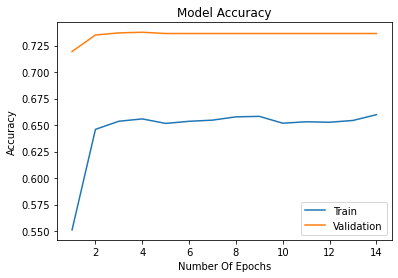

In [ ]:
import matplotlib.pyplot as plt
epochs=[x for x in range(1,15)]
plt.plot(epochs,history.history['accuracy'])
plt.plot(epochs,history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number Of Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


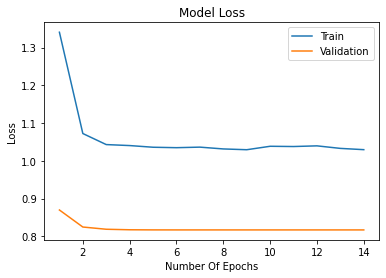

In [ ]:
epochs=[x for x in range(1,15)]
plt.plot(epochs,history.history['loss'])
plt.plot(epochs,history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number Of Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()